In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"

synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
retrieval_src_path=my_git_path+"/hamp_retrieval_haloac3/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,synth_ar_path+"src/")
sys.path.insert(4,synth_ar_path+"plotting/")
sys.path.insert(5,hamp_processing_path)
sys.path.insert(6,hamp_processing_path+"plotting/")
sys.path.insert(7,retrieval_src_path+"src/")
sys.path.insert(8,start_path+"/../plotting/")
import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA 
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"

synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
retrieval_src_path=my_git_path+"/hamp_retrieval_haloac3/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,synth_ar_path+"src/")
sys.path.insert(4,synth_ar_path+"plotting/")
sys.path.insert(5,hamp_processing_path)
sys.path.insert(6,hamp_processing_path+"plotting/")
sys.path.insert(7,retrieval_src_path+"src/")
sys.path.insert(8,start_path+"/../plotting/")
import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA 
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [3]:
def get_icon_precipitation_and_hmps(flight_dates={"RF05":"20220315","RF06":"20220316"},
                               ars_of_day=["AR_entire_1","AR_entire_2"],
                                  sector_to_plot=["S1","S2","S3","S4"]):
    halo_icon_hmps={}
    halo_icon_ivts={}
    precip_rates={}
    s=0
    flights=[*flight_dates.keys()]
    sectors=sector_to_plot
    for flight in flights:
        for ar_of_day in ars_of_day:
            from simplified_flight_leg_handling import simplified_run_grid_main
            with HiddenPrints():
                halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes=\
                simplified_run_grid_main(flight=[flight],config_file_path=major_work_path,ar_of_day=ar_of_day)
        
            sector=sector_to_plot[s]
    
            # ICON File
            icon_major_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
            hydrometeor_icon_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
            icon_resolution=2000 # units m
            upsample_time="20min"
            date=flight_dates[flight]
            interp_icon_hmp_file=flight+"_"+ar_of_day+"_"+"interpolated_HMP.csv"
            interp_icon_ivt_file=flight+"_"+ar_of_day+"_"+"ICON_Interpolated_IVT.csv"
            icon_var_list=ICON.lookup_ICON_AR_period_data(cmpgn_cls.name,[flight],ar_of_day,
                                                 icon_resolution,
                                                 hydrometeor_icon_path,
                                                 synthetic=False)

            ICON_on_HALO=Grid_on_HALO.ICON_on_HALO(
            cmpgn_cls,icon_var_list,halo_df,[flight],date,
            interpolated_hmp_file=interp_icon_hmp_file,
            interpolated_hmc_file=None,ar_of_day=ar_of_day,
            upsample_time=upsample_time,
            synthetic_icon=False,
            synthetic_flight=False)

            hydrometeor_icon_path=hydrometeor_icon_path+flight+"/"
            ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)
            halo_icon_ivts[flight+"_"+ar_of_day]=pd.read_csv(hydrometeor_icon_path+interp_icon_ivt_file,index_col=0)
            halo_icon_ivts[flight+"_"+ar_of_day]["Sector"]=sector
            halo_icon_hmps[flight+"_"+ar_of_day]=ICON_on_HALO.load_interpolated_hmp()
            halo_icon_hmps[flight+"_"+ar_of_day]["Sector"]=sector
            # read precip rates########
            rate_path =cmpgn_cls.campaign_path+"/data/precip_rates/"
            rate_fname="warm"+"_precip_"+flight+"_"+ar_of_day+".csv"
            halo_precip_rates[flight+"_"+ar_of_day]=pd.read_csv(rate_path+rate_fname,index_col=0)
            halo_precip_rates[flight+"_"+ar_of_day]["Sector"]=s+1
            print(halo_precip_rates[flight+"_"+ar_of_day]["rate"].describe())
            ############
            s+=1
    merged_rates        =pd.concat(precip_rates.values())
    merged_halo_icon_hmp=pd.concat(halo_icon_hmps.values())
    merged_halo_icon_hmp.index=pd.DatetimeIndex(merged_halo_icon_hmp.index)
    merged_halo_icon_ivt=pd.concat(halo_icon_ivts.values())
    return merged_rates,merged_halo_icon_hmp,merged_halo_icon_ivt

## Definitions and Configurations

In [4]:
sectors={"RF05_AR_entire_1":"S1",
         "RF05_AR_entire_2":"S2",
         "RF06_AR_entire_1":"S3",
         "RF06_AR_entire_2":"S4"}

campaign="HALO_AC3"
flight="RF05"
ar_of_day="AR_entire_1"
sector=sectors[flight+"_"+ar_of_day]
index_pos=int(sector[-1])-1

## Budget components data

#### HALO

In [5]:
#---------------------------------------------------------------------------------------
# Moisture transport divergence
halo_sonde_values={}
halo_sonde_values["RF05_AR_entire_1"]={
  'mass_div': -0.41276886889204784,
  'mass_div_min': -0.7301260286358718,
  'mass_div_max': -0.09541170914822367,
  'q_ADV': -0.7907497132061316,
  'q_ADV_min': -1.565287488594897,
  'q_ADV_max': -0.016211937817365973}
halo_sonde_values["RF05_AR_entire_2"]={
    'mass_div': -0.1882352622233449,
    'mass_div_min': -0.6452538732851526,
    'mass_div_max': 0.2687833488384628,
    'q_ADV': -0.5474630545351018,
    'q_ADV_min': -1.3557554102823333,
    'q_ADV_max': 0.2608293012121298}
halo_sonde_values["RF06_AR_entire_1"]={
     'mass_div': -0.22776075016667244,
     'mass_div_min': -0.5096074494526325,
     'mass_div_max': 0.05408594911928759,
     'q_ADV': -0.7544264531963553,
     'q_ADV_min': -1.3814041637839345,
     'q_ADV_max': -0.12744874260877628}
halo_sonde_values["RF06_AR_entire_2"]={
    'mass_div': -0.41276886889204784,
    'mass_div_min': -0.7301260286358718,
    'mass_div_max': -0.09541170914822367,
    'q_ADV': -0.7907497132061316,
    'q_ADV_min': -1.565287488594897,
    'q_ADV_max': -0.016211937817365973}
#    'mass_div': -0.23570411496183644,
#    'mass_div_min': -0.602622062208785,
#    'mass_div_max': 0.13121383228511205,
#    'q_ADV': -0.7594541149453358,
#    'q_ADV_min': -1.497718568202485,
#    'q_ADV_max': -0.021189661688186773}
#-----------------------------------------------------------------------------------
# local change in water vapour
d_IWV_dt_sonde=pd.Series(data=[-0.25,-0.34,0.05,np.nan],index=["S1","S2","S3","S4"]) 
d_IWV_dt_hamp=pd.Series(data=[-0.49,-0.31,0.66,np.nan],index=["S1","S2","S3","S4"]) 
# evaporation
halo_evap=pd.Series(data=[np.nan,np.nan,np.nan,np.nan],index=["S1","S2","S3","S4"])
# precipitation
with HiddenPrints():
    precip_rates,halo_icon_hmp,halo_icon_ivt=get_precipitation_and_hmps()
halo_precip_rates=precip_rates
halo_precip_rates.index=pd.DatetimeIndex(halo_precip_rates.index)

NameError: name 'get_precipitation_and_hmps' is not defined

In [120]:
#halo_icon_hmp["Interp_Precip"].loc["2022-03-15 10:20":"2022-03-15 10:41"]
#halo_precip_rates["rate"].loc["2022-03-15 10:20":"2022-03-15 10:41"]
merged_rates=pd.DataFrame(data=np.nan,columns=["Precip\nHALO","Precip\nICON"],
                          index=halo_icon_hmp["Interp_Precip"].loc[halo_precip_rates.loc["2022-03-15 10:20":"2022-03-15 10:41"].index].index)
merged_rates["Precip\nICON"]=halo_icon_hmp["Interp_Precip"].loc[\
                                                halo_precip_rates.loc["2022-03-15 10:20":"2022-03-15 10:41"].index].values
merged_rates["Precip\nHALO"]=halo_precip_rates["rate"].loc["2022-03-15 10:20":"2022-03-15 10:41"].values
merged_rates

,Precip\nHALO,Precip\nICON
time,,
2022-03-15 10:20:00,0.000000,0.000000
2022-03-15 10:20:01,0.000000,0.000000
2022-03-15 10:20:02,0.000000,0.000000
2022-03-15 10:20:03,0.000000,0.000000
2022-03-15 10:20:04,0.000000,0.000000
...,...,...
2022-03-15 10:41:38,0.022518,0.197954
2022-03-15 10:41:39,0.023811,0.193901
2022-03-15 10:41:40,0.024575,0.189846


#### ICON

In [143]:
ICON_Evap_Sectors=pd.DataFrame(data=np.nan,columns=["mean","std"],index=sectors)
ICON_Evap_Sectors["mean"]=[0.002438,0.00275,-0.015,-0.0038]
ICON_Evap_Sectors["std"]=[0.006509,0.005,0.0083,0.0101]

d_IWV_dt_icon=pd.Series(data=[0.19,np.nan,np.nan,np.nan],index=["S1","S2","S3","S4"])
ICON_div={}
ICON_div["RF05_AR_entire_1"]={
  'mass_div': -0.27,
  'mass_div_min': -0.51,
  'mass_div_max': -0.02,
  'q_ADV': -0.38,
  'q_ADV_min': -0.73,
  'q_ADV_max': -0.03}

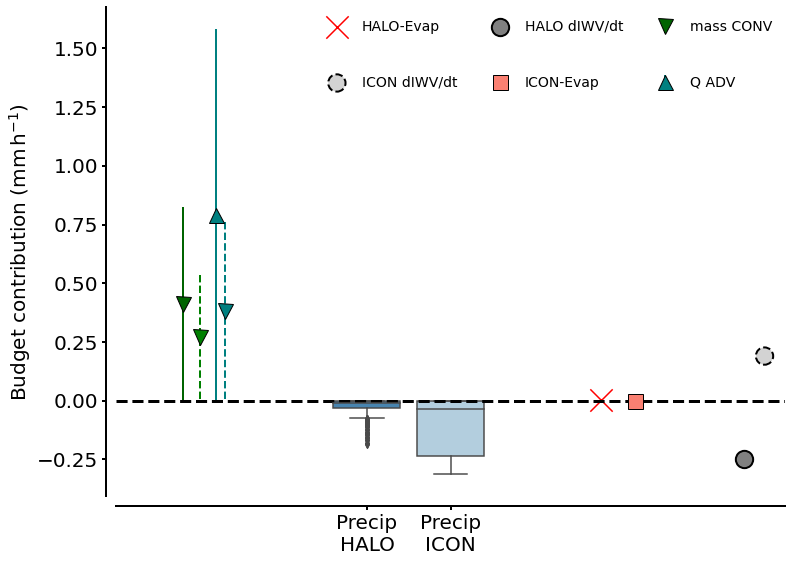

In [144]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams.update({"font.size":20})

budget_components_fig, (ax1) =plt.subplots(1,1,figsize=(12,9))
#sns.boxplot(data=merged_halo_icon_ivt, x="Sector", y="IVT",ax=ax1,palette=["darkgreen","seagreen","teal","lightseagreen"])
#ax1.set_xlabel(" ")
# Evaporation
ax1.errorbar([3.2], -1*ICON_Evap_Sectors["mean"].values[0], yerr=ICON_Evap_Sectors["std"].values[0], marker='s', mfc='salmon',
         mec='black', ecolor="r",ms=15, mew=1,ls="",label="ICON-Evap")
ax1.scatter([2.8], 0.001, marker='x', s=500,color="r",label="HALO-Evap")

#Mass Convergence
#sns.boxplot(data=merged_rates,x="Sector",y="rate",ax=ax2,color="blue")
#ax1.set_ylabel("IVT ($\mathrm{kgm}^{-1}{\mathrm{s}}^{-1}$")
halo_sonde_values["RF05_AR_entire_1"]={
  'mass_div': -0.41276886889204784,
  'mass_div_min': -0.7301260286358718,
  'mass_div_max': -0.09541170914822367,
  'q_ADV': -0.7907497132061316,
  'q_ADV_min': -1.565287488594897,
  'q_ADV_max': -0.016211937817365973}
ax1.errorbar([-2.2],-1*halo_sonde_values[flight+"_"+ar_of_day]["mass_div"],
            yerr=[(halo_sonde_values[flight+"_"+ar_of_day]["mass_div_max"]--\
                   halo_sonde_values[flight+"_"+ar_of_day]["mass_div_min"])/2],
            marker="v",ms=15,markeredgecolor="k",mfc="darkgreen",elinewidth=2,ecolor="darkgreen",ls="",label="mass CONV")
conv_e2=ax1.errorbar([-2.0],-1*ICON_div[flight+"_"+ar_of_day]["mass_div"],
            yerr=[(ICON_div[flight+"_"+ar_of_day]["mass_div_max"]--\
                   ICON_div[flight+"_"+ar_of_day]["mass_div_min"])/2],
            marker="v",ms=15,markeredgecolor="k",mfc="green",elinewidth=2,
             ecolor="green")
conv_e2[-1][0].set_linestyle('--')
#Q ADV
ax1.errorbar([-1.8],-1*halo_sonde_values[flight+"_"+ar_of_day]["q_ADV"],
            yerr=[(halo_sonde_values[flight+"_"+ar_of_day]["q_ADV_max"]--\
                   halo_sonde_values[flight+"_"+ar_of_day]["q_ADV_min"])/2],
            marker="^",ms=15,markeredgecolor="k",mfc="teal",elinewidth=2,ecolor="teal",ls="",label="Q ADV")

adv_e2=ax1.errorbar([-1.7],-1*ICON_div[flight+"_"+ar_of_day]["q_ADV"],
            yerr=[(ICON_div[flight+"_"+ar_of_day]["q_ADV_max"]--\
                   ICON_div[flight+"_"+ar_of_day]["q_ADV_min"])/2],
            marker="v",ms=15,markeredgecolor="k",mfc="teal",elinewidth=2,
             ecolor="teal",)
adv_e2[-1][0].set_linestyle('--')
sns.boxplot(data=-1*merged_rates,width=0.8,ax=ax1,palette="Blues_r")
             #IWV tendency
ax1.scatter(4.75,0.19,marker='o',s=300, facecolors='lightgrey', edgecolors='k',linestyle='--',linewidth=2,
           label="ICON dIWV/dt")
ax1.scatter(4.5,-0.25,marker='o',s=300, facecolors='grey', edgecolors='k',linestyle='-',linewidth=2,
           label="HALO dIWV/dt")
#ax2.scatter(np.array([1,2,3])+0.1,np.array([-0.25,-0.34,0.05]),
#            marker="o",s=200,edgecolor="k",facecolor="grey",label="IWV tendency \n(Dropsondes)")
#ax2.scatter(np.array([1,2,3])+0.1,np.array([-0.49,-0.31,0.66]),
#            marker="o",s=75,edgecolor="k",facecolor="lightgrey",label="IWV tendency \n(HAMP)")
##
#ax2.axhline(y=0,ls="--",lw=1,color="k")
#ax2.set_xlim([0.5,4.5])
#ax2.set_ylabel("Budget Contribution ($\mathrm{mmh}^{-1}$)")
#ax2.set_xticks([1,2,3,4])
#ax2.set_xticklabels(["S1","S2","S3","S4"])#
#ax2.set_ylim([-1.0,1.2])
ax1.spines['left'].set_linewidth(2)
ax1.axhline(y=0,ls="--",lw=3,color="k")
#ax1.set_xticks([-2,-1,0,1,2])
#ax2.spines['left'].set_linewidth(2)
ax1.set_xlim([-3,5])
ax1.spines['bottom'].set_linewidth(2)
#ax2.spines['bottom'].set_linewidth(2)
ax1.xaxis.set_tick_params(width=2,length=4)
ax1.yaxis.set_tick_params(width=2,length=4)
#ax2.xaxis.set_tick_params(width=2,length=4)
#ax2.yaxis.set_tick_params(width=2,length=4)
ax1.set_ylabel("Budget contribution ($\mathrm{mm}\,\mathrm{h}^{-1}$)")
ax1.legend(loc="upper right",ncol=3,frameon=False,fontsize=14,labelspacing = 3)
import matplotlib.patches as mpatches
sns.despine(offset=10)
budget_components_fig.savefig(os.getcwd()+"/../plots/"+"Single_AR_Budget_components_sections.png",dpi=300,bbox_inches="tight")